<a href="https://colab.research.google.com/github/AlperYildirim1/Pay-Attention-Later/blob/main/Inspect_Resonances_Superposition_added.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q x-transformers

In [ ]:
# ==========================================
# 1. SETUP & MODEL LOADING (FIXED)
# ==========================================
import os
import sys
from huggingface_hub import hf_hub_download

# --- CRITICAL FIX: Download the Model Definition FIRST ---
REPO_ID = "Yujivus/PRISM-Molecule-100k"
filename = "modeling_prism_gated.py"

print(f"⬇️ Downloading {filename} from Hugging Face...")
if not os.path.exists(filename):
    hf_hub_download(repo_id=REPO_ID, filename=filename, local_dir=".", force_download=True)

# Now that the file exists locally, we can import it
sys.path.append(".") # Ensure current dir is in path
from modeling_prism_gated import PRISMHybrid_RoPE

# Continue with standard imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer
import json

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
D_MODEL = 512

print("⏳ Downloading Weights & Config...")
if not os.path.exists("config.json"):
    hf_hub_download(repo_id=REPO_ID, filename="config.json", local_dir=".")
if not os.path.exists("pytorch_model.bin"):
    hf_hub_download(repo_id=REPO_ID, filename="pytorch_model.bin", local_dir=".")

with open("config.json", "r") as f: config = json.load(f)
tokenizer = AutoTokenizer.from_pretrained(REPO_ID)

# Initialize Model
model = PRISMHybrid_RoPE(
    vocab_size=config['vocab_size'], d_model=config['d_model'],
    num_encoder_layers=config['num_encoder_layers'], num_refining_layers=0,
    num_decoder_layers=6, num_heads=8, dff=2048, max_length=128, dropout=0.0
).to(DEVICE)

model.load_state_dict(torch.load("pytorch_model.bin", map_location=DEVICE))
model.eval()
print("✅ Model Loaded Successfully.")

In [ ]:
# @title 🧭 Extended Phase Compass: Synonyms vs Antonyms vs Randoms
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer
from huggingface_hub import hf_hub_download
import os
import json


# ==========================================
# 2. DEFINING THE CANDIDATE PAIRS
# ==========================================
# Master list of all candidates
candidates_raw = [
    # --- ORIGINAL LIST ---
    ("Euro", "Geld", "Synonym"),
    ("Auto", "Wagen", "Synonym"),
    ("schnell", "rasch", "Synonym"),
    ("Stimme", "Wahl", "Synonym"),
    ("Zeit", "Uhr", "Synonym"),
    ("Start", "Beginn", "Synonym"),
    ("Ende", "Schluss", "Synonym"),
    ("Raum", "Platz", "Synonym"),

    # --- NEW GERMAN SYNONYMS ---
    ("Haus", "Heim", "Synonym"),
    ("Boot", "Schiff", "Synonym"),
    ("See", "Meer", "Synonym"),
    ("Wald", "Forst", "Synonym"),
    ("Weg", "Pfad", "Synonym"),
    ("Berg", "Gipfel", "Synonym"),
    ("Mund", "Maul", "Synonym"),
    ("Pferd", "Ross", "Synonym"),
    ("Hund", "Tier", "Synonym"),
    ("Reise", "Fahrt", "Synonym"),
    ("Angst", "Furcht", "Synonym"),
    ("Mut", "Traute", "Synonym"),
    ("Glück", "Dusel", "Synonym"),
    ("Ding", "Sache", "Synonym"),
    ("Welt", "Erde", "Synonym"),
    ("Stadt", "Ort", "Synonym"),
    ("Vater", "Papa", "Synonym"),
    ("Mutter", "Mama", "Synonym"),
    ("klug", "weise", "Synonym"),
    ("klug", "schlau", "Synonym"),
    ("schön", "hübsch", "Synonym"),
    ("klein", "winzig", "Synonym"),
    ("stark", "fest", "Synonym"),
    ("neu", "frisch", "Synonym"),
    ("still", "leise", "Synonym"),
    ("froh", "heiter", "Synonym"),
    ("dunkel", "finster", "Synonym"),
    ("kalt", "eisig", "Synonym"),
    ("rennen", "laufen", "Synonym"),
    ("reden", "sagen", "Synonym"),
    ("sehen", "schauen", "Synonym"),
    ("gehen", "wandern", "Synonym"),
    ("essen", "speisen", "Synonym"),

    # --- NEW ANTONYMS (OPPOSITES) ---
    ("gut", "böse", "Antonym"),
    ("groß", "klein", "Antonym"),
    ("heiß", "kalt", "Antonym"),
    ("Tag", "Nacht", "Antonym"),
    ("hoch", "tief", "Antonym"),
    ("jung", "alt", "Antonym"),
    ("voll", "leer", "Antonym"),
    ("Liebe", "Hass", "Antonym"),
    ("Krieg", "Frieden", "Antonym"),
    ("Licht", "Schatten", "Antonym"),
    ("Mann", "Frau", "Antonym"),
    ("Start", "Ziel", "Antonym"),
    ("Frage", "Antwort", "Antonym"),

    # --- NEW RANDOM/UNRELATED ---
    ("Mond", "Tisch", "Random"),
    ("Brot", "Wolke", "Random"),
    ("Schuh", "Idee", "Random"),
    ("Baum", "Zahn", "Random"),
    ("Glas", "Löwe", "Random"),
    ("Buch", "Suppe", "Random"),
    ("Wand", "Vogel", "Random"),
    ("Gras", "Auto", "Random"),
    ("Salz", "Musik", "Random"),
    ("Dach", "Fisch", "Random"),
    ("Stein", "Wort", "Random"),
    ("Kopf", "Preis", "Random"),
    ("Hand", "Woche", "Random"),
    ("Euro", "Apfel", "Random"),
    ("Auto", "Idee", "Random"),
    ("schnell", "Haus", "Random"),
    ("Zeit", "Fisch", "Random"),
    ("Start", "Milch", "Random"),
    ("Raum", "Laufen", "Random")
]

# ==========================================
# 3. HELPER FUNCTIONS
# ==========================================
def is_single_token(word):
    """Check if word is 1 token in vocabulary."""
    ids = tokenizer.encode(word, add_special_tokens=False)
    return len(ids) == 1, ids[0] if len(ids) == 1 else None

def calculate_coherence(id_a, id_b):
    """Extract phases and calculate Mean Resultant Length (R)."""
    # 1. Get Weights (CPU)
    w = model.harmonic_embedding.complex_embedding.weight.detach().cpu()

    # 2. Form Complex Numbers (Real + i*Imag)
    za = torch.complex(w[id_a, :D_MODEL], w[id_a, D_MODEL:])
    zb = torch.complex(w[id_b, :D_MODEL], w[id_b, D_MODEL:])

    # 3. Phase Difference (Angle between vectors)
    diff = torch.angle(za) - torch.angle(zb)

    # 4. Energy Weighting (Magnitude * Magnitude)
    #    Stronger concepts contribute more to the "Phase Compass"
    weights = torch.abs(za) * torch.abs(zb)

    # 5. Convert to Numpy
    diff_np = diff.numpy()
    weights_np = weights.numpy()

    # 6. Calculate Circular Mean (R)
    #    R ranges from 0 (Random/Cancel) to 1 (Perfect Alignment)
    weighted_complex_diffs = weights_np * np.exp(1j * diff_np)
    mean_vector = np.sum(weighted_complex_diffs) / np.sum(weights_np)

    return np.abs(mean_vector), np.angle(mean_vector), diff_np, weights_np

# ==========================================
# 4. EXECUTE ANALYSIS
# ==========================================
valid_pairs = []
results = []

print(f"\n{'Pair':<25} | {'Type':<10} | {'Status':<15} | {'R (Coherence)'}")
print("-" * 75)

for w1, w2, ptype in candidates_raw:
    s1, id1 = is_single_token(w1)
    s2, id2 = is_single_token(w2)

    if s1 and s2:
        R, angle, diffs, weights = calculate_coherence(id1, id2)
        valid_pairs.append({
            "w1": w1, "w2": w2, "type": ptype,
            "R": R, "angle": angle, "diffs": diffs, "weights": weights
        })
        results.append({"Pair": f"{w1}-{w2}", "Type": ptype, "R": R})
        print(f"{w1}-{w2:<20} | {ptype:<10} | ✅ Valid        | {R:.4f}")
    else:
        # Just logging for info, skipped in analysis
        pass
        # print(f"{w1}-{w2:<20} | {ptype:<10} | ❌ Multi-token  | -")

# ==========================================
# 5. STATISTICS
# ==========================================
df = pd.DataFrame(results)
print("\n📊 AGGREGATE STATS (Mean Resultant Length R):")
print(df.groupby("Type")["R"].describe())

# ==========================================
# 6. VISUALIZATION (GRID 3x3)
# ==========================================
# Select Top 3 from each category to show clearest examples
synonyms = sorted([p for p in valid_pairs if p["type"] == "Synonym"], key=lambda x: x["R"], reverse=True)[:3]
antonyms = sorted([p for p in valid_pairs if p["type"] == "Antonym"], key=lambda x: x["R"], reverse=True)[:3]
randoms  = sorted([p for p in valid_pairs if p["type"] == "Random"],  key=lambda x: x["R"], reverse=False)[:3] # Lowest R for randoms

plot_list = synonyms + antonyms + randoms

if len(plot_list) > 0:
    fig = plt.figure(figsize=(15, 12))
    fig.suptitle("Semantic Phase Compass: Synonyms vs Antonyms vs Randoms", fontsize=16, y=0.98)

    # Colors for categories
    colors = {"Synonym": "red", "Antonym": "purple", "Random": "blue"}

    for i, item in enumerate(plot_list):
        ax = fig.add_subplot(3, 3, i+1, projection='polar')

        ptype = item["type"]
        color = colors[ptype]

        # Weighted Histogram of Phase Differences
        ax.hist(item["diffs"], bins=30, weights=item["weights"], color=color, alpha=0.7, density=True)

        # Mean Vector Arrow (The "Compass Needle")
        # Length of arrow = R (Coherence Strength)
        ax.annotate("", xy=(item["angle"], item["R"]), xytext=(0,0),
                    arrowprops=dict(facecolor='black', width=2, headwidth=10))

        # Styling
        ax.set_title(f"{item['w1']} - {item['w2']}\n{ptype}\nR = {item['R']:.3f}", fontsize=11)
        ax.set_yticklabels([]) # Hide radial labels
        ax.set_xticklabels([]) # Hide angular labels

    plt.tight_layout()
    plt.savefig("phase_compass_extended.png", dpi=300)
    plt.show()
    print("\n📸 Saved plot to 'phase_compass_extended.png'")
else:
    print("⚠️ Not enough valid pairs to generate plot.")

🌊 DYNAMIC RESONANCE ANALYSIS: SUPERPOSITION vs COLLAPSE

📌 Context: 'Fluss Wasser Ufer Bank'
   Target: 'Bank' vs Candidates: 'Fluss' (Correct) / 'Geld' (Wrong)
   L0: Correct R=0.113 | Wrong R=0.110 --> Superposition ⚖️
   L1: Correct R=0.121 | Wrong R=0.112 --> Superposition ⚖️
   L2: Correct R=0.128 | Wrong R=0.114 --> Superposition ⚖️
   L3: Correct R=0.123 | Wrong R=0.109 --> Superposition ⚖️
   L4: Correct R=0.127 | Wrong R=0.103 --> Resonance ✅
   L5: Correct R=0.148 | Wrong R=0.114 --> Resonance ✅
--------------------------------------------------
📌 Context: 'Geld Zinsen Kredit Bank'
   Target: 'Bank' vs Candidates: 'Kredit' (Correct) / 'Wasser' (Wrong)
   L0: Correct R=0.191 | Wrong R=0.095 --> Resonance ✅
   L1: Correct R=0.190 | Wrong R=0.100 --> Resonance ✅
   L2: Correct R=0.187 | Wrong R=0.102 --> Resonance ✅
   L3: Correct R=0.182 | Wrong R=0.102 --> Resonance ✅
   L4: Correct R=0.181 | Wrong R=0.095 --> Resonance ✅
   L5: Correct R=0.175 | Wrong R=0.108 --> Resonance ✅


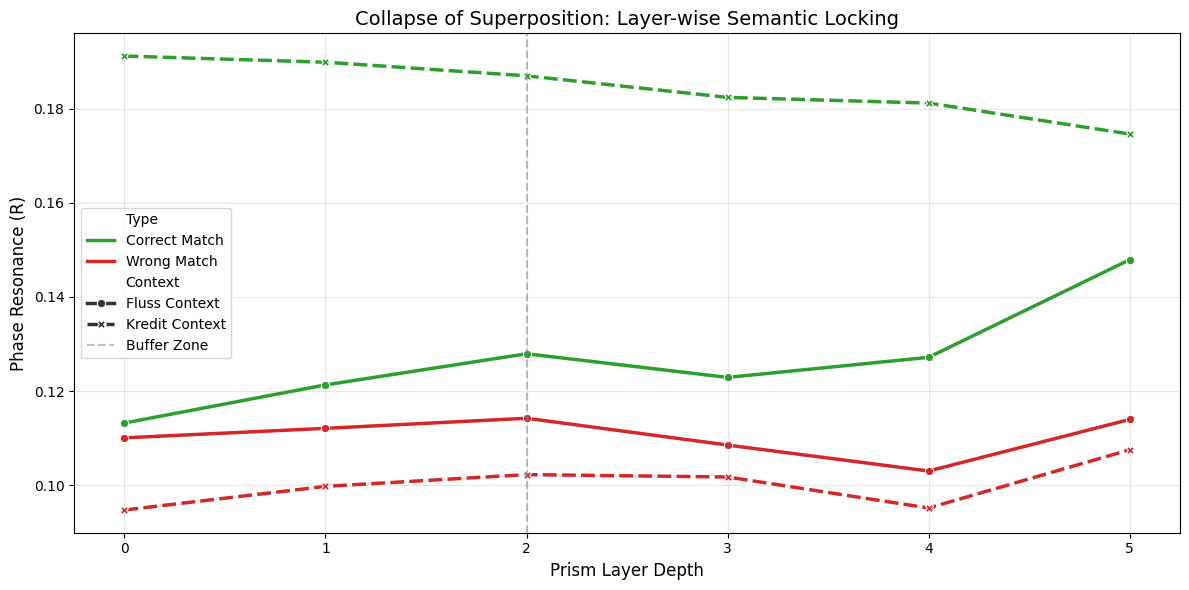

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Dataframe için ekledim

# ==============================================================================
# 1. SETUP (FIXED)
# ==============================================================================
scenarios = [
    {
        "context": "Fluss Wasser Ufer Bank", # Nehir Bağlamı
        "target": "Bank",
        "candidate_correct": "Fluss", # Nehir
        "candidate_wrong": "Geld"     # Para
    },
    {
        "context": "Geld Zinsen Kredit Bank", # Finans Bağlamı
        "target": "Bank",
        "candidate_correct": "Kredit", # Kredi
        "candidate_wrong": "Wasser"    # Su
    }
]

layer_activations = {}

def get_activation_hook(name):
    def hook(module, input, output):
        # Bridge katmanlarını atlayıp sadece Complex PRISM çıktılarını alıyoruz
        if torch.is_complex(output):
            layer_activations[name] = output.detach().cpu() # ZATEN CPU'YA ALIYOR
    return hook

def find_token_idx(text, word, tokenizer):
    # 1. Hedef kelimenin ID'sini bul (Tek başına)
    target_ids = tokenizer.encode(word, add_special_tokens=False)
    # Eğer kelime parçalanıyorsa (bpe) ilk parçasını al
    target_id = target_ids[0]

    # 2. Cümlenin tamamının ID'lerini al
    context_ids = tokenizer.encode(text, add_special_tokens=False)

    # 3. ID listesinde hedefi ara
    for i, tid in enumerate(context_ids):
        if tid == target_id:
            return i

    print(f"⚠️ KRİTİK HATA: '{word}' (ID: {target_id}) cümlede bulunamadı! Tokenler: {context_ids}")
    return -1

def calculate_layer_coherence(vec_a, vec_b):
    # İkisi de CPU'da olmalı
    diff = torch.angle(vec_a) - torch.angle(vec_b)
    weights = torch.abs(vec_a) * torch.abs(vec_b)

    weighted_diffs = weights.numpy() * np.exp(1j * diff.numpy())
    # Sıfıra bölme hatasını önlemek için epsilon ekleyelim
    total_weight = np.sum(weights.numpy()) + 1e-9
    mean_vector = np.sum(weighted_diffs) / total_weight

    return np.abs(mean_vector)

# ==============================================================================
# 2. EXECUTION LOOP (FIXED DEVICE HANDLING)
# ==============================================================================
model.eval()
model.prism_encoder.apply(lambda m: m._forward_hooks.clear())

# Hookları tak
for i, layer in enumerate(model.prism_encoder.layers):
    layer.register_forward_hook(get_activation_hook(f"Layer_{i}"))

history = []

print(f"{'='*80}")
print(f"🌊 DYNAMIC RESONANCE ANALYSIS: SUPERPOSITION vs COLLAPSE")
print(f"{'='*80}\n")

for sc in scenarios:
    # --- FIX: REFERANS VEKTÖRLERİNİ CPU'YA AL ---
    with torch.no_grad():
        # Correct Aday
        ids_c = tokenizer(sc["candidate_correct"], return_tensors="pt").to(DEVICE)
        # Modelden çıktı alıp hemen CPU'ya taşıyoruz:
        emb_c = model.harmonic_embedding(ids_c["input_ids"])[0, 0, :].detach().cpu()

        # Wrong Aday
        ids_w = tokenizer(sc["candidate_wrong"], return_tensors="pt").to(DEVICE)
        # Modelden çıktı alıp hemen CPU'ya taşıyoruz:
        emb_w = model.harmonic_embedding(ids_w["input_ids"])[0, 0, :].detach().cpu()

    # Context Forward Pass
    inputs = tokenizer(sc["context"], return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        x = model.harmonic_embedding(inputs["input_ids"])
        src_mask = (inputs["input_ids"] == tokenizer.pad_token_id)
        model.prism_encoder(x, src_mask)

    # Target Token Index
    target_idx = find_token_idx(sc["context"], sc["target"], tokenizer)
    if target_idx == -1:
        print(f"⚠️ Warning: Target '{sc['target']}' not found via exact match.")
        target_idx = 0 # Fallback

    print(f"📌 Context: '{sc['context']}'")
    print(f"   Target: '{sc['target']}' vs Candidates: '{sc['candidate_correct']}' (Correct) / '{sc['candidate_wrong']}' (Wrong)")

    # Layerları sırayla gez
    # Keys might be unsorted, so we explicitly sort indices
    available_layers = [k for k in layer_activations.keys() if k.startswith("Layer_")]
    layer_indices = sorted([int(k.split("_")[1]) for k in available_layers])

    for i in layer_indices:
        # Target Vec (Zaten CPU'da, Hook sağ olsun)
        target_vec = layer_activations[f"Layer_{i}"][0, target_idx, :]

        # Artık hepsi CPU'da, işlem hatasız çalışacak
        r_correct = calculate_layer_coherence(target_vec, emb_c)
        r_wrong = calculate_layer_coherence(target_vec, emb_w)

        history.append({
            "Context": sc["candidate_correct"] + " Context",
            "Layer": i,
            "Resonance": r_correct,
            "Type": "Correct Match"
        })
        history.append({
            "Context": sc["candidate_correct"] + " Context",
            "Layer": i,
            "Resonance": r_wrong,
            "Type": "Wrong Match"
        })

        state = "Superposition ⚖️"
        if r_correct > r_wrong * 1.2: state = "Resonance ✅" # Eşiği biraz düşürdüm (1.5 -> 1.2)
        if r_wrong > r_correct: state = "Confusion ❌"

        print(f"   L{i}: Correct R={r_correct:.3f} | Wrong R={r_wrong:.3f} --> {state}")
    print("-" * 50)

# ==============================================================================
# 3. VISUALIZATION
# ==============================================================================
if len(history) > 0:
    df = pd.DataFrame(history)

    plt.figure(figsize=(12, 6))
    # Context'e göre stil, Doğru/Yanlış'a göre renk
    sns.lineplot(data=df, x="Layer", y="Resonance", hue="Type", style="Context", markers=True, linewidth=2.5, palette=["tab:green", "tab:red"])

    plt.title("Collapse of Superposition: Layer-wise Semantic Locking", fontsize=14)
    plt.ylabel("Phase Resonance (R)", fontsize=12)
    plt.xlabel("Prism Layer Depth", fontsize=12)
    plt.grid(True, alpha=0.3)

    # Layer 2 Buffer Çizgisi
    plt.axvline(x=2, color='gray', linestyle='--', alpha=0.5, label="Buffer Zone")

    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No data collected. Check layer hooks.")